In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (16,10)

# Car Pricing

You've been given a dataset describing various features of some cars including their list price.

  * https://m2pi.syzygy.ca/data/CarPrice_Assignment.csv

You've been asked to explore this dataset, present some summary statistics and (hopefully) build a model for setting the list price. We've broken the problem down into 3 stages...


### Part 1: Exploration and Cleaning
1. Read in this data, clean and tidy it if necessary
1. Calculate basic statistics to understand what you have been given
1. Select some columns which might be correlated with price

### Part 2: Analysis and Model Building
1. Create training and testing sets
1. Scale things if needed
1. Fit a pricing model

### Part 3: Results
1. Apply your model and summarize your findings

## Part 1: Hints

In [21]:
wCSV = 'https://m2pi.syzygy.ca/data/CarPrice.csv'
wDF = pd.read_csv(
    wCSV,
    index_col='car_ID',
    usecols=[
        'car_ID',
        'CarName',
        'doornumber',
        'enginelocation',
        'curbweight',
        'enginesize',
        'compressionratio',
        'horsepower',
        'peakrpm',
        'highwaympg',
        'citympg',
        'price'
    ]
)

`pd.DataFrame.head()` can give you a quick summary of what you have

In [22]:
wDF.head()

,CarName,doornumber,enginelocation,curbweight,enginesize,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,
1,alfa-romero giulia,two,front,2548,130,9.0,111,5000,'21',27,13495.0
2,alfa-romero stelvio,two,front,2548,130,9.0,111,5000,'21',27,16500.0
3,alfa-romero Quadrifoglio,two,front,2823,152,9.0,154,5000,'19',26,16500.0
4,audi 100 ls,four,front,2337,109,10.0,102,5500,'24',30,13950.0
5,audi 100ls,four,front,2824,136,8.0,115,5500,'18',22,17450.0


It is also useful to examine the detected datatypes of the columns to spot any potential problems.

In [23]:
wDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CarName           205 non-null    object 
 1   doornumber        205 non-null    object 
 2   enginelocation    205 non-null    object 
 3   curbweight        205 non-null    int64  
 4   enginesize        205 non-null    int64  
 5   compressionratio  205 non-null    float64
 6   horsepower        205 non-null    int64  
 7   peakrpm           205 non-null    int64  
 8   citympg           205 non-null    object 
 9   highwaympg        205 non-null    int64  
 10  price             205 non-null    float64
dtypes: float64(2), int64(5), object(4)
memory usage: 19.2+ KB


In the table head `citympg` looks like it should be `int64` but it was detected as `object`. If you look closely at that column you'll see it has been added as a (double-)quoted string. Pandas is smart enough to figure out one level of quoting but 2 is too much! There are a few different ways to coerce this back to `int64`, for example we can strip of one level of quotes and pass it to `pd.to_numeric`

In [24]:
wDF['citympg'] = pd.to_numeric(wDF['citympg'].apply(lambda x: x.replace("'", '')))

The `pd.DataFrame.describe()` method gives you a quick summary of the numerical values in your data

In [26]:
wDF.describe()

,curbweight,enginesize,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2555.565854,126.907317,10.142537,104.117073,5125.121951,25.219512,30.751220,13228.125205
std,520.680204,41.642693,3.972040,39.544167,476.985643,6.542142,6.886443,8039.255967
min,1488.000000,61.000000,7.000000,48.000000,4150.000000,13.000000,16.000000,-1.000000
25%,2145.000000,97.000000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,2414.000000,120.000000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2935.000000,141.000000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,4066.000000,326.000000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


The `price` column has at least one record with the value `-1`. When you see a value like this or `NaN` it is generally there as a missing data marker. Pandas has good facilities for working with `Nan` but this is our target variable, so we'll just hold it aside for now

In [27]:
unpriced = wDF[wDF['price'] == -1]
unpriced

,CarName,doornumber,enginelocation,curbweight,enginesize,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,
81,mitsubishi mirage g4,two,front,2370,110,7.5,116,5500,23,30,-1.0


In [28]:
wDF = wDF.drop(wDF[wDF['price'] == -1].index)

`pd.DataFrame.describe()` only shows us the numerical fields, for categorical fields like `doornumber` and `enginelocation` value counts are more informative

In [29]:
wDF.doornumber.value_counts()

four    115
two      89
Name: doornumber, dtype: int64

In [30]:
wDF.enginelocation.value_counts()

front    201
rear       3
Name: enginelocation, dtype: int64

In [32]:
wDF['doornumber'] = wDF.doornumber.astype("category")
wDF['enginelocation'] = wDF.enginelocation.astype("category")

`CarName` is probably useless for our needs, but before we throw it away lets look at some of the values to get an idea what is in there

In [33]:
np.unique(wDF[wDF['CarName'].str.contains('toy')]['CarName'])

array(['toyota carina', 'toyota celica gt', 'toyota celica gt liftback',
       'toyota corolla', 'toyota corolla 1200',
       'toyota corolla 1600 (sw)', 'toyota corolla liftback',
       'toyota corolla tercel', 'toyota corona', 'toyota corona hardtop',
       'toyota corona liftback', 'toyota corona mark ii',
       'toyota cressida', 'toyota mark ii', 'toyota starlet',
       'toyota tercel', 'toyouta tercel'], dtype=object)

`'toyouta tercel'` is clearly a typo. In this case I'm just going to drop the column and ignore it, but it might be worth pulling out the manufacturer and model to see if that correlates with price. It is worth doing some basic sanity checks with any categorical fields you have to look for similar problems. 

In [34]:
wDF.drop('CarName', axis=1, inplace=True)

`enginelocation` is nice and tidy but us currently detected as an object, let's make it a categorical variable

### Correlations

Next lets start looking for some correlations, one way to do this is via correlation coefficients. We can normalize any (floating point) columns then visualize the results as a heatmap to see the correlations at a glance.

There are a few ways of normlaizing the data but since we'll be using sklearn later on let's use the `StandardScalar` for that. `StandardScalar` will subtract the mean from each variable and divide by the standard deviation, this should center the values of each column around 0 with unit variance.

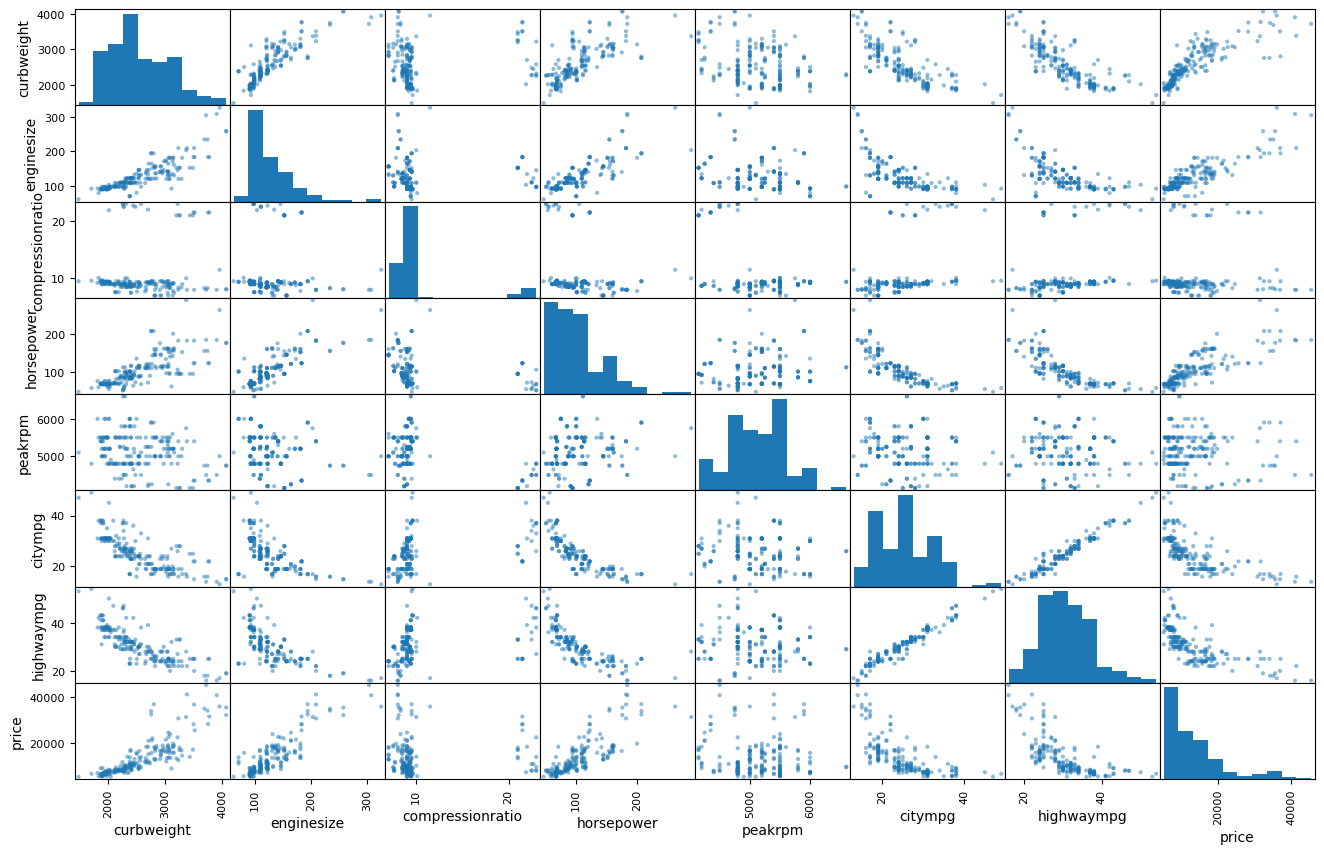

In [36]:
from pandas.plotting import scatter_matrix
scatter_matrix(wDF);

In [39]:
cols = [c for c in wDF.columns if wDF[c].dtype in (np.float64, np.int64)]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
wDF_scaled = pd.DataFrame(
    scaler.fit_transform(wDF[cols]),
    wDF.index,
    columns=cols
)

In [40]:
wDF_scaled

,curbweight,enginesize,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,
1,-0.016283,0.072306,-0.291224,0.175569,-0.258860,-0.646821,-0.545276,0.025299
2,-0.016283,0.072306,-0.291224,0.175569,-0.258860,-0.646821,-0.545276,0.401608
3,0.512038,0.600825,-0.291224,1.263202,-0.258860,-0.952618,-0.690493,0.401608
4,-0.421649,-0.432189,-0.039189,-0.052075,0.790988,-0.188125,-0.109625,0.082278
5,0.513959,0.216448,-0.543258,0.276744,0.790988,-1.105516,-1.271361,0.520575
...,...,...,...,...,...,...,...,...
201,0.759868,0.336566,-0.165206,0.251450,0.581019,-0.341024,-0.400059,0.444812
202,0.946221,0.336566,-0.366834,1.414965,0.371049,-0.952618,-0.835710,0.720313
203,0.875138,1.105320,-0.341631,0.757326,0.790988,-1.105516,-1.126144,1.025868


A lot of models rely on the data being approximately normally distributed, it is sometimes taking a quick look at the distribution of your data

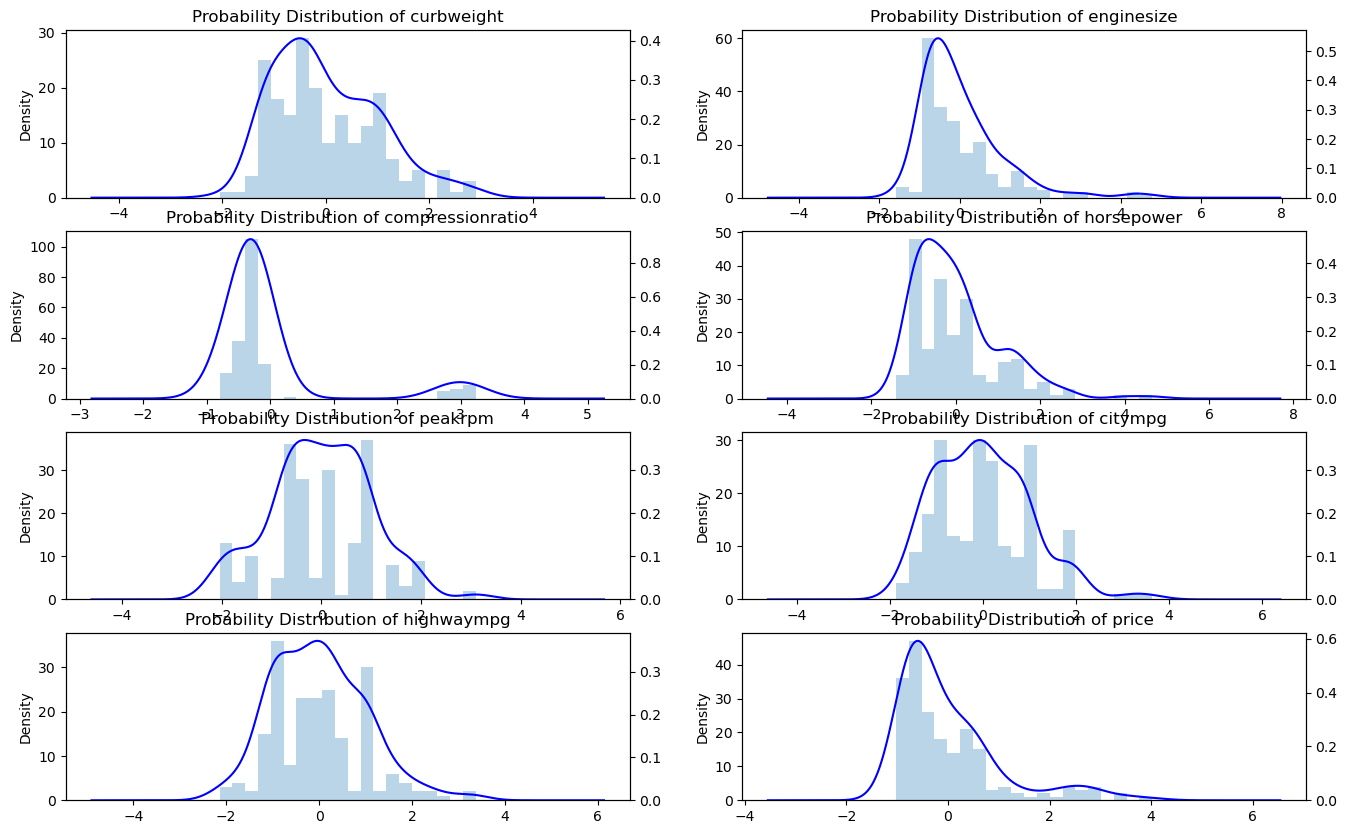

In [42]:
fig, axes = plt.subplots(len(cols) // 2, 2)

for i, feature in enumerate(cols):
    ax = axes[i // 2, i % 2]
    wDF_scaled[feature].plot.hist(ax = ax, bins=20, alpha=0.3)
    wDF_scaled[feature].plot.kde(ax = ax, secondary_y=True, color='blue')
    ax.set_ylim(0)
    ax.right_ax.set_ylim(0)
    ax.set_title(f"Probability Distribution of {feature}")

peak_rpm is a bit worrying, but the rest don't seem too terrible to me so let's look at the correlations

<Axes: >

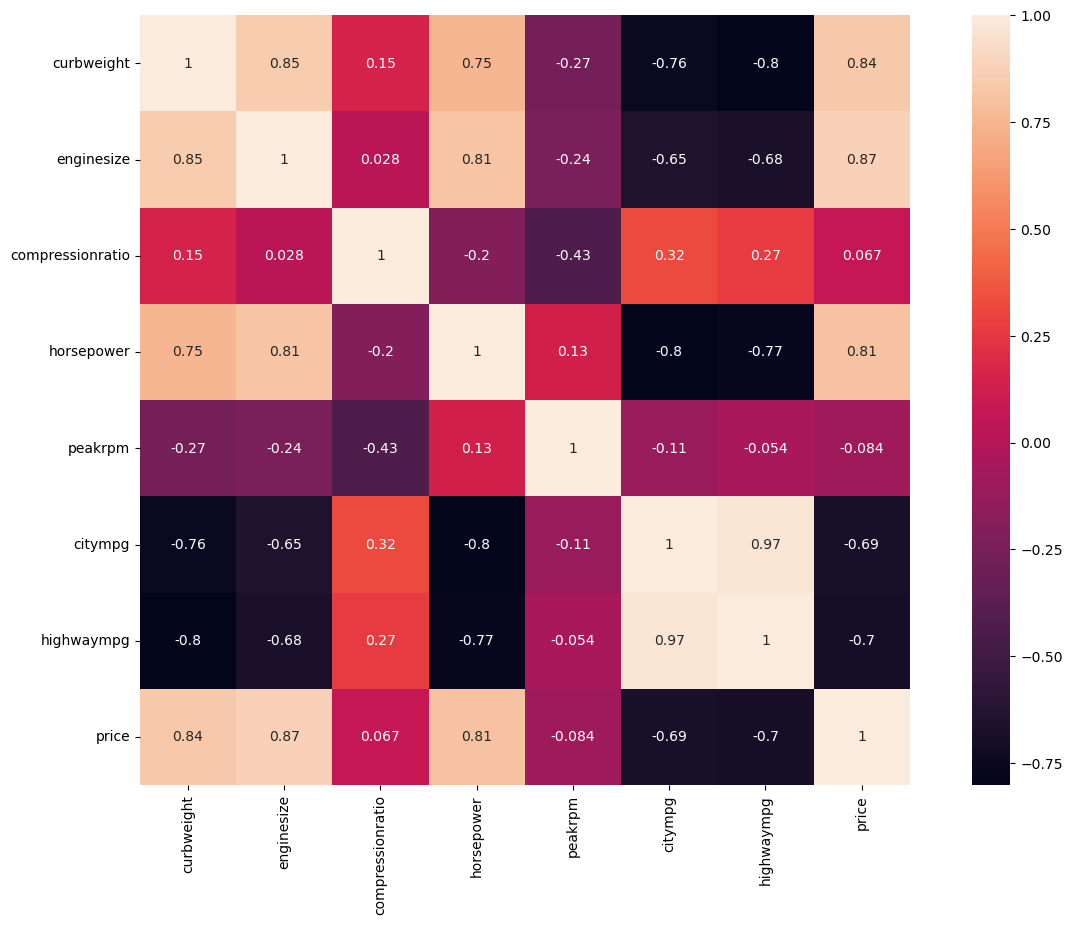

In [43]:
sns.heatmap(
    wDF_scaled.corr(), 
    cbar=True,
    annot = True,
    square = True
)

So it looks like `price` might be correlated with `curbweight`, `engingsize` and `horsepower` and might be negatively correlated with `highwaympg` and `citympg`. Thankfully there doesn't seem to be much correlation with `peakrpm`.

So far we have ignored the categorical variables like `enginelocation`. Another way to look for correlations in those is with a boxplot

<Axes: xlabel='enginelocation', ylabel='price'>

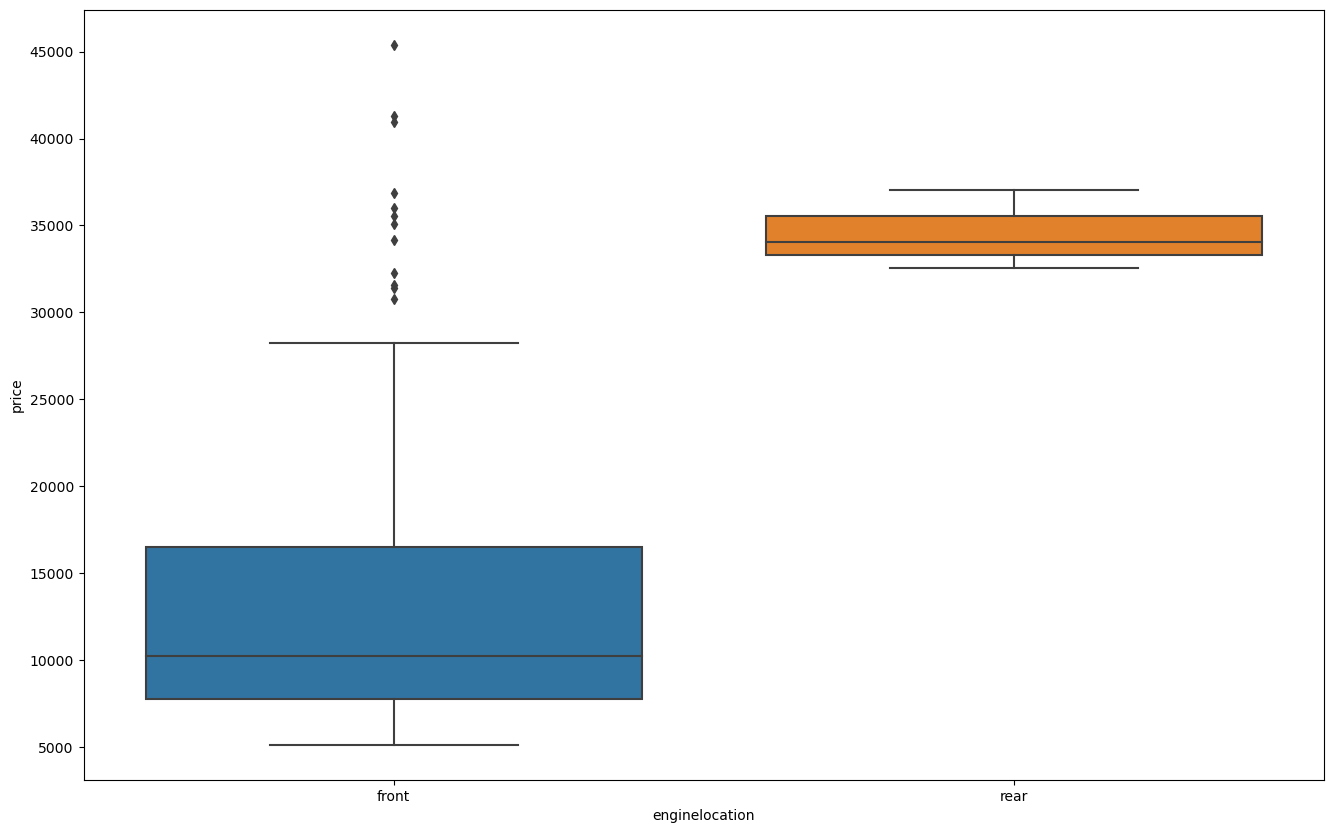

In [45]:
sns.boxplot(x='enginelocation', y='price', data=wDF)

<Axes: xlabel='price', ylabel='Density'>

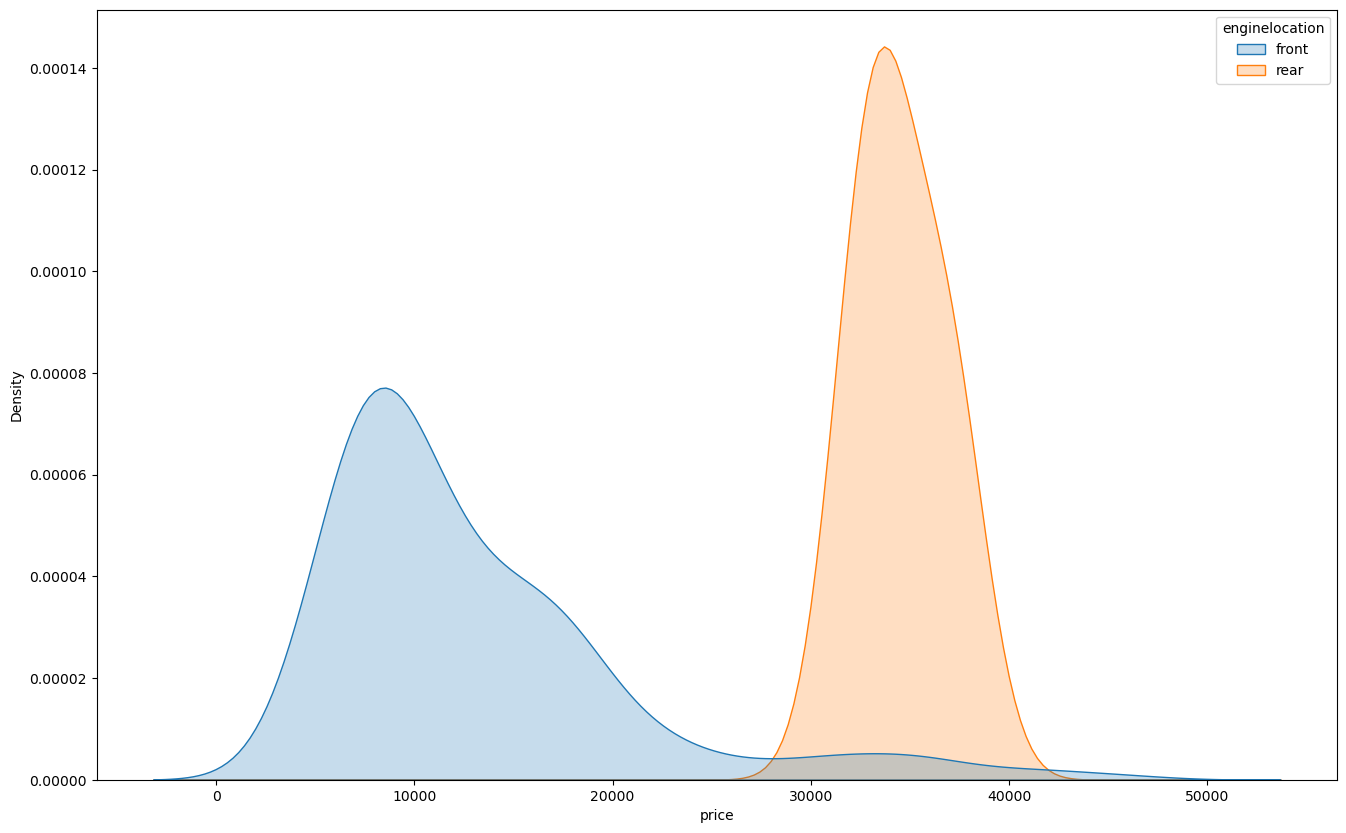

In [46]:
sns.kdeplot(
     data=wDF, 
     x='price',
     hue='enginelocation',
     common_norm=False,
     common_grid=True,
     fill=True
)

This is basically saying that rear engined cars are more expensive! There are a few expensive front engined cars, but on average they're cheaper.

We can also directly plot things against `price` to see some of the correlation

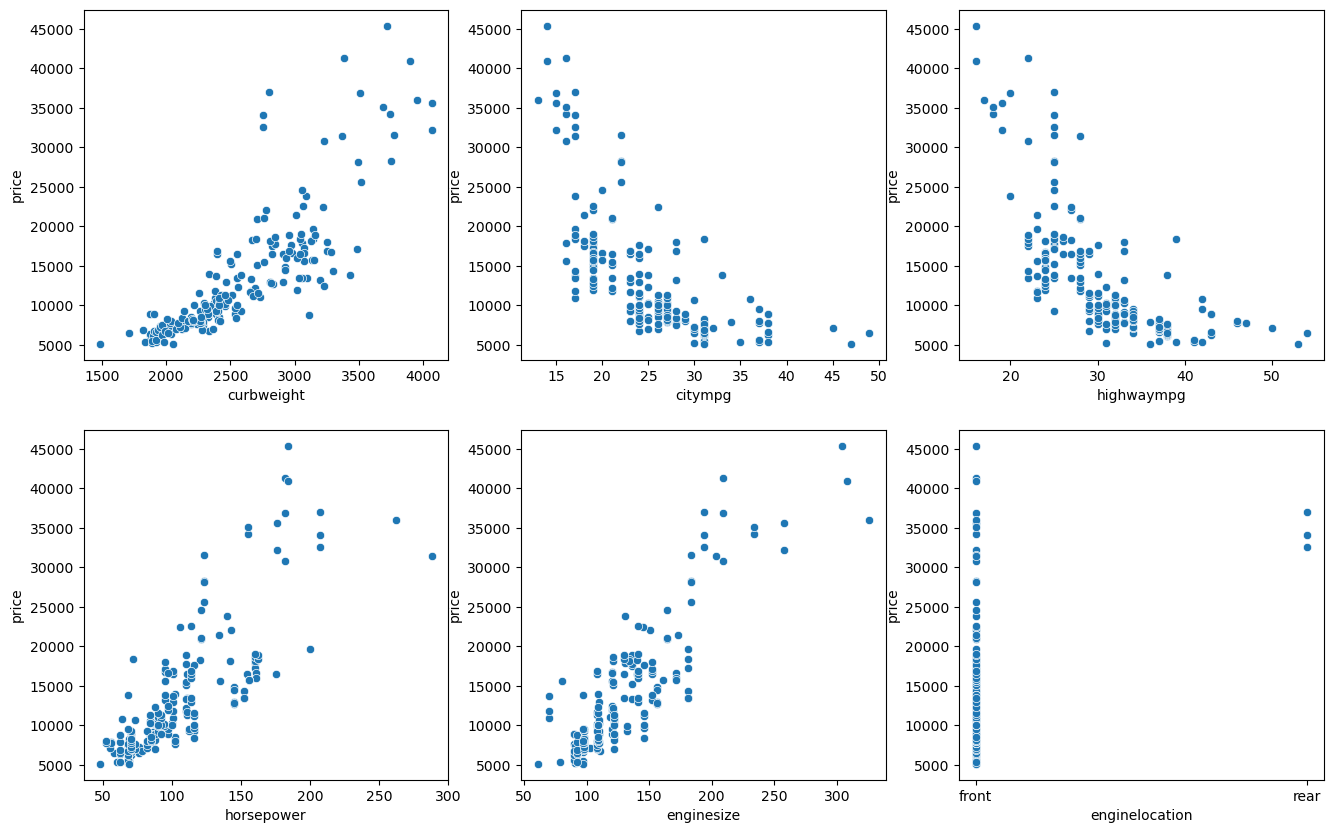

In [47]:
selected_cols = ['curbweight', 'citympg', 'highwaympg', 'horsepower', 'enginesize', 'enginelocation']
fig, ax = plt.subplots(2, 3)
for index, item in enumerate(selected_cols):
    row, col = index//3, index % 3
    sns.scatterplot(x = wDF[item], y = wDF['price'], ax=ax[row, col])

My takeaway from this would be that there is enough structure there to usefully fit. Let's see if we can do that!

## Part 2

First we will split the test and training data. It looks like the price might be correlated with the engine position so we would like to make sure we sample without bias

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 47)

for train_idx, test_idx in split.split(wDF, wDF['enginelocation']):
    train_strat = wDF.iloc[train_idx]
    test_strat = wDF.iloc[test_idx]

X_train = train_strat.drop('price', axis=1)
y_train = train_strat['price']

X_test = test_strat.drop('price', axis=1)
y_test = test_strat['price']

Text(0.5, 1.0, 'Training Set')

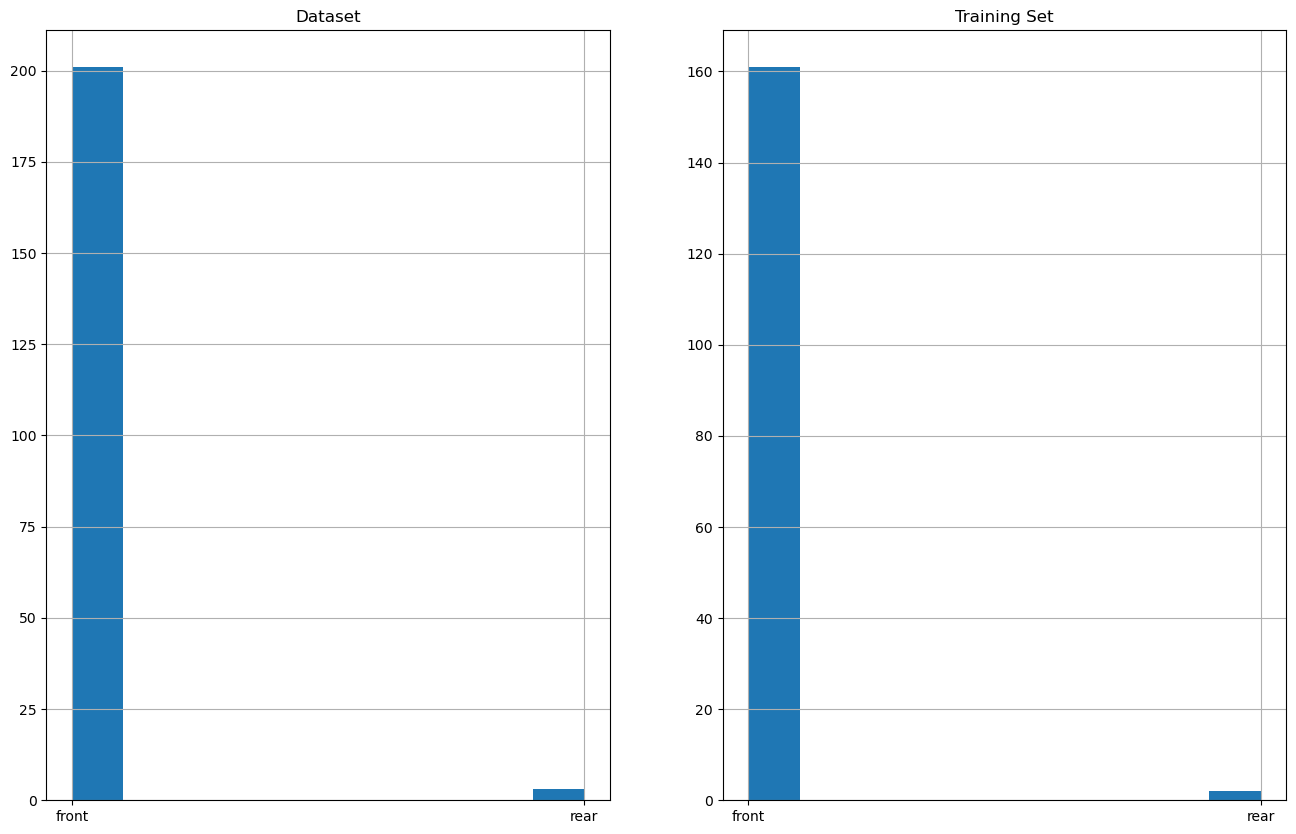

In [49]:
fig, axes = plt.subplots(1, 2)

wDF['enginelocation'].hist(ax=axes[0])
axes[0].set_title('Dataset')
                  
train_strat['enginelocation'].hist(ax=axes[1])
axes[1].set_title('Training Set')

Those look roughly similar so we'll proceed. Next, we want to scale things so that the various models will have reasonable values to work with. We'll use the `StandardScaler` for the numerical columns and `OneHotEncoder` for the categorical ones.

In [50]:
num_cols = [
    'curbweight',
    'enginesize',
    'compressionratio',
    'horsepower',
    'peakrpm',
    'citympg',
    'highwaympg'
]
cat_cols = ['doornumber', 'enginelocation']

In [51]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

transform = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

In [53]:
X_train_tr = transform.fit_transform(X_train)

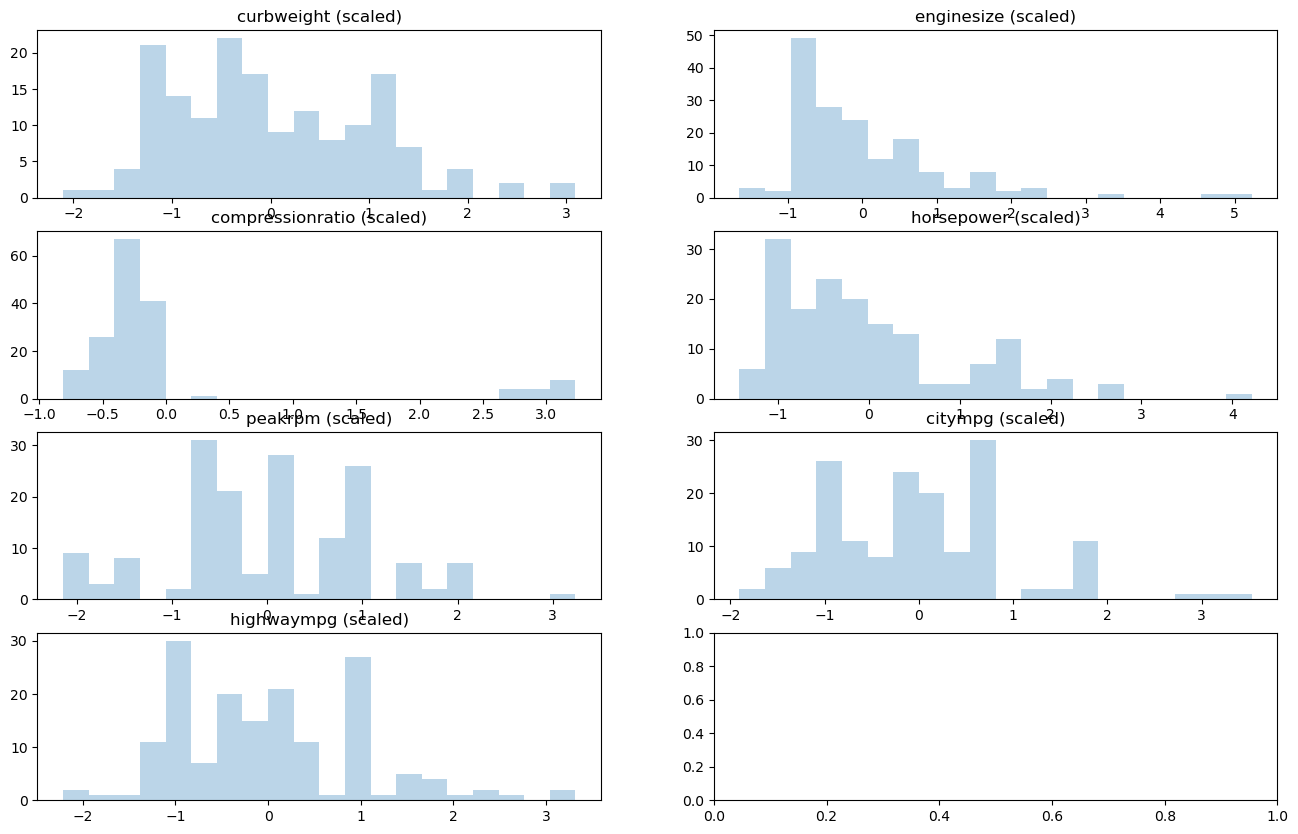

In [54]:
fig, axes = plt.subplots(4, 2)
for i, feature in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    ax.hist(X_train_tr[:, i], bins=20, alpha=0.3)
    ax.set_title(f"{feature} (scaled)")

## Training a model

In [55]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()

model_lr.fit(X_train_tr, y_train)
y_train_pred = model_lr.predict(X_train_tr)

We can look at the residuals to get an idea of how our model is doing

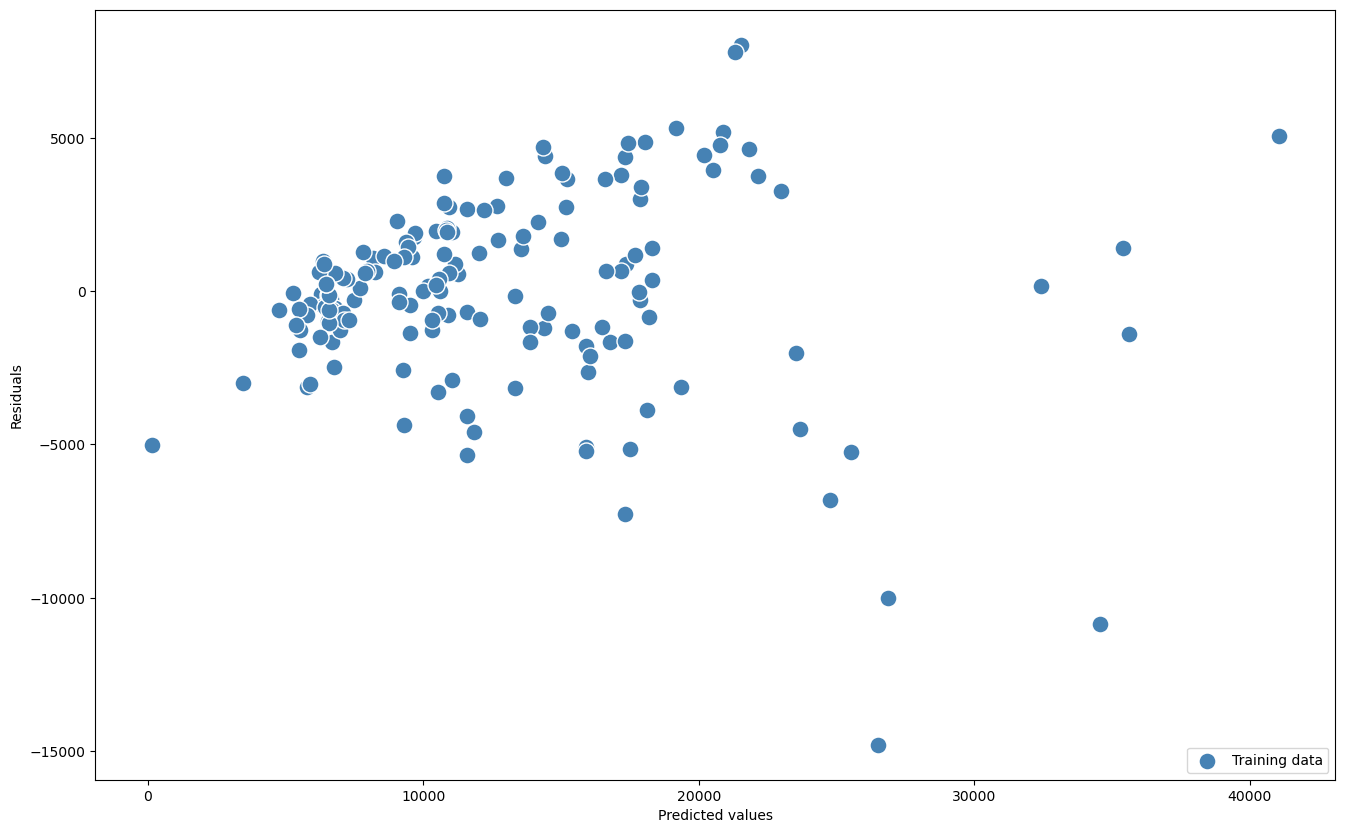

In [56]:
fig,ax = plt.subplots()

ax.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', s=150, edgecolor='white',
            label='Training data')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
ax.legend(loc='upper left')
ax.legend(loc='lower right')


In [62]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print(f"RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"R^2 train: {r2_score(y_train, y_train_pred)}")

RMSE train: 3116.683
R^2 train: 0.8215564557704408


First we need to transform the columns, then we can try to predict

In [63]:
unpriced

,CarName,doornumber,enginelocation,curbweight,enginesize,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,
81,mitsubishi mirage g4,two,front,2370,110,7.5,116,5500,23,30,-1.0


How about trying it on the row we set aside at the start?

In [60]:
price = model_lr.predict(transform.transform(unpriced.drop('price', axis=1)))
price
#transform.inverse_transform(price)

array([11501.30823815])

The actual list price was \$9959 so "not great, not terrible"

A bit more systematically do k-fold cross validation to see if your RMSE is stable

In [61]:
from sklearn.model_selection import cross_val_score

In [64]:
scores = cross_val_score(model_lr, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

3299.1476173768397 += 1076.46966936208


## Other Models

You should consult the [choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) page to see where to go next, but I'm going to jump to a completely different model type. Random Forest is a well established technique for classification problems, but sklearn also includes `RandomForestRegressor` which is a meta estimator which fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. In this case it is almost certainly too powerful and if we were using it in real life we'd want a lot more checks and balances to make sure we understand the model before using it in production

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
model_rf = RandomForestRegressor()

model_rf.fit(X_train_tr, y_train)
y_train_pred = model_rf.predict(X_train_tr)


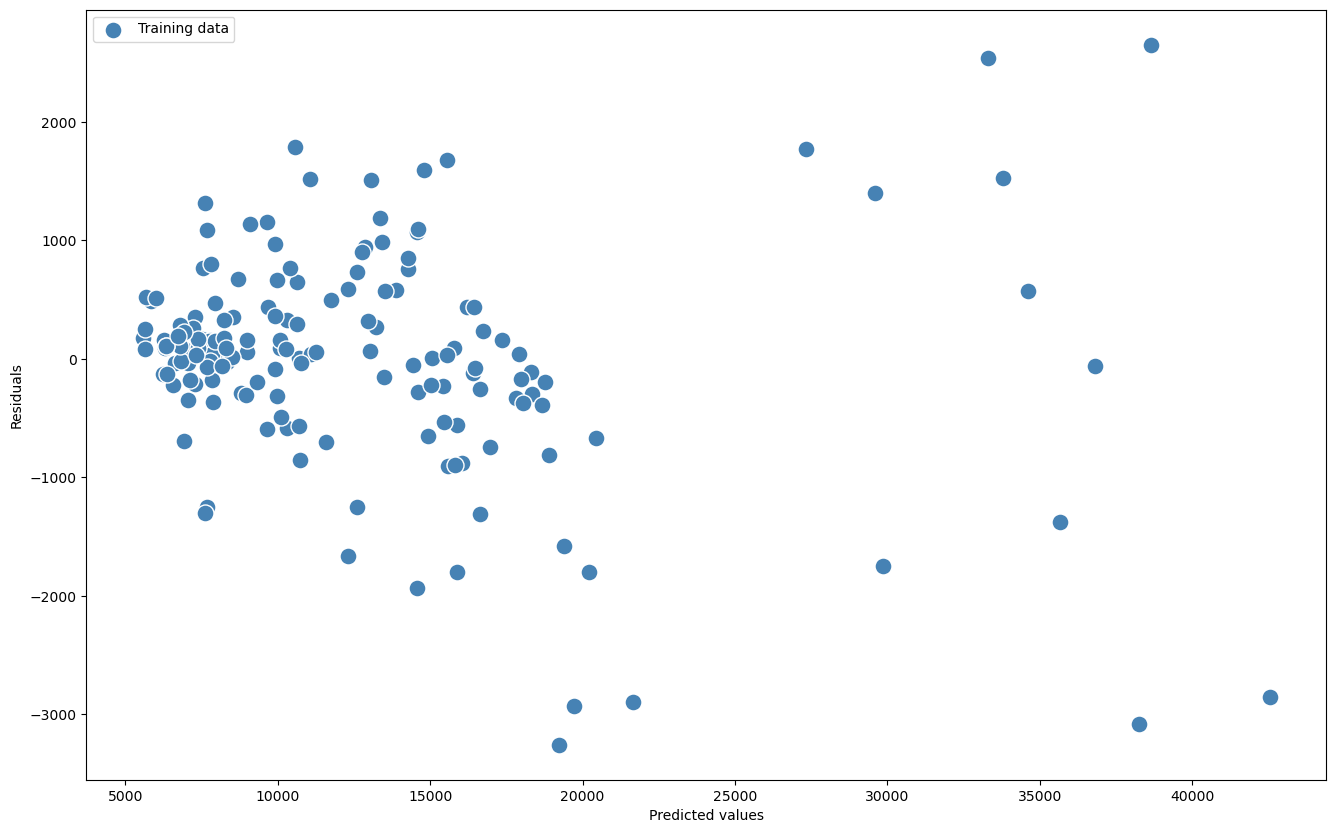

In [67]:
fig,ax = plt.subplots()

ax.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', s=150, edgecolor='white',
            label='Training data')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
ax.legend(loc='upper left')

In [68]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print(f"RMSE train: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"R^2 train: {r2_score(y_train, y_train_pred)}")

RMSE train: 922.160
R^2 train: 0.9843782907320271


In [69]:
transform.transform(unpriced.drop('price', axis=1))

array([[-0.32587711, -0.37619289, -0.68455665,  0.36962082,  0.82314631,
        -0.39469764, -0.17499302,  0.        ,  1.        ,  1.        ,
         0.        ]])

In [70]:
price = model_rf.predict(transform.transform(unpriced.drop('price', axis=1)))
price

array([13002.28333333])

Again, the actual list price was \$9959

In [72]:
scores = cross_val_score(model_rf, X_train_tr, y_train,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

2152.5930689400366 += 597.529576392607


So it does a fair bit better than the linear model even without playing with hyperparameters.

### Tuning Hyperparameters

So for now we decided to stick with `RandomForestRegressor`. The next thing would be to tune the hyperparameters for the model

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=47)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(model_rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_tr, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [75]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}

In [77]:
grid_search.best_estimator_.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [78]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

3030.8854093222812 {'max_features': 2, 'n_estimators': 3}
2420.773587049834 {'max_features': 2, 'n_estimators': 10}
2481.1758511779326 {'max_features': 2, 'n_estimators': 30}
2797.410008696112 {'max_features': 4, 'n_estimators': 3}
2469.979217752631 {'max_features': 4, 'n_estimators': 10}
2342.331202934963 {'max_features': 4, 'n_estimators': 30}
2928.526373972364 {'max_features': 6, 'n_estimators': 3}
2485.4357418068935 {'max_features': 6, 'n_estimators': 10}
2332.176934943633 {'max_features': 6, 'n_estimators': 30}
2822.066328065015 {'max_features': 8, 'n_estimators': 3}
2402.2897002512354 {'max_features': 8, 'n_estimators': 10}
2228.716907949407 {'max_features': 8, 'n_estimators': 30}
3205.540158327603 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2176.5385136840855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
2394.0935432220804 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2349.4192146687924 {'bootstrap': False, 'max_features': 3, 'n_estimato

This doesn't seem particularly sensitive to these parameters, but anyway

## Part 3

We'll say that we are happy with our model and now it is time to open the test data set and see how it performs

In [80]:
final_model = grid_search.best_estimator_

X_test_prepared = transform.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"{final_rmse}")

2858.1544398050046


Alright...